In [8]:
#Math Part
import numpy as np
import pandas as pd

#Graph
import matplotlib.pyplot as plt

import importlib
import circuit
import encoding
import qsvm
import fitness
import gsvm
importlib.reload(circuit)
importlib.reload(encoding)
importlib.reload(qsvm)
importlib.reload(fitness)
importlib.reload(gsvm)

import pandas as pd
import time

#def evol(output="sample_iot_result_n5.csv"):
output="sample_iot_result_n5.csv"
iot_data = pd.read_csv('sample_iot_data.csv')
y = iot_data['pump'].values
X = iot_data[['moisture','temp']].values
start = time.time()
pop, pareto, logbook = gsvm.gsvm(nqubits=6, depth=3, nparameters=2,
                            X=X, y=y, weights=[-1.0,1.0],
                            mu=50,lambda_=10, ngen=200)
print(f'Simulation finished after {time.time()-start} seconds')
print(f'\nGenetic-algorithm output ({output})')
#print('generation, individual, gates/qubit, accuracy')
print('---------------------------------------------')
# print(logbook)
with open(output, "w") as f:
    for ide, ind in enumerate(pareto):
        genes=''.join(str(i) for i in list(ind))
        gates, acc = ind.fitness.values
        line = f'{ide},"{genes}",{gates},{acc}'
        f.write(line)
        f.write('\n')
        print(line)
                
#evol()

d:\Anaconda\envs\qc\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMulti' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
d:\Anaconda\envs\qc\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


String: 011011010000100010110000000011010110111011111001100010111110010110011110011111001011110001
 -> accuracy = 0.925, gates = 17.0,recall = 1.0
String: 110101101010010010101010100111100001001010110100100110011010000000000111010101100111001010
 -> accuracy = 0.825, gates = 10.0,recall = 0.9666666666666667
String: 110001100011111110010100100001100001101101110010100101101100011000100111000110011000111001
 -> accuracy = 0.8, gates = 7.0,recall = 1.0
String: 111010000011000111110010110000010100101101101010000111110110100011000100001101011100011010
 -> accuracy = 0.95, gates = 11.0,recall = 1.0
String: 111110000111111010100100110111001000000000001101000000100011011110101100101101111100100001
 -> accuracy = 0.875, gates = 13.0,recall = 1.0
String: 011011010110100110000100011001100111101100100101000011011011100101010110000110010010101100
 -> accuracy = 0.875, gates = 11.0,recall = 0.9666666666666667
String: 100000110110111001110011000011101111100100011010011101011001001001111011101110101111

In [9]:
import encoding2 as e2
import random

iot_result = pd.read_csv('sample_iot_result_n5.csv',header=None)

def ordenar_salidas_pareto(dataframe):
    dataframe.columns=['ind','circ','gates','acc']
    dataframe.sort_values(['acc','gates'], ascending=[False,False],inplace=True)
    dataframe.reset_index(inplace=True)
    dataframe.pop('index')
    return dataframe

iot_salidas = ordenar_salidas_pareto(iot_result)
iot_salidas # Queremos ver el primer circuito del dataframe yya ordenado por accuracy (mejor ind)

,ind,circ,gates,acc
0,188,1000011000110111100101000010111100001010101100...,1.000000,1.000
1,156,1100011000111001100101000010001101111010101111...,0.650208,0.975
2,157,1000010100111111100010100110001101111010101100...,0.650208,0.975
3,158,1100011000111001100101000010001101111010101111...,0.650208,0.975
4,159,1100011000111001100101000110001101111010101100...,0.650208,0.975
...,...,...,...,...
184,43,1100011000110111100011000010111100001010101111...,0.000000,0.750
185,44,1100011000110111100010100110001101111010101111...,0.000000,0.750
186,45,1100011000110111100010100110001101111010101111...,0.000000,0.750
187,46,1100011000110111100010100110001101111010101100...,0.000000,0.750


['10000', '11000', '11011', '11001', '01000', '01011', '11000', '01010', '10110', '01110', '01000', '10111', '11010', '01001', '11000', '11001', '10000', '11001']
3.0


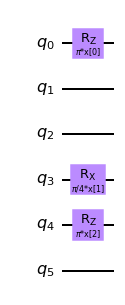

In [13]:
from qiskit.circuit import ParameterVector, QuantumCircuit, Parameter
from qiskit import execute, Aer, IBMQ, QuantumRegister, ClassicalRegister, BasicAer
# from qiskit.aqua import QuantumInstance
def coding_bits(b):
    c = [b[n:n+5] for n,i in enumerate(b) if n%5==0]
    c_p=[]
    coding_0=[]
    for i in range(len(c)):
        for j in c[i]:
            c_p.append(str(j))
    np.asarray(c_p)
    c = [c_p[n:n+5] for n,i in enumerate(c_p) if n%5==0]
    for i in c:
        coding_0.append(''.join(i))
    return coding_0

class CircuitConversor:

    def __init__(self, nqubits, nparameters):
        gates = {}
        for n, suffix in enumerate(['00','01','10','11']):
            angle = np.pi / (2**n)
            gates['000'+suffix] = (self.make_H(), 1.0)
            gates['001'+suffix] = (self.make_cx(), 2.0)
            gates['010'+suffix] = (self.make_id(), 0.0)
            gates['011'+suffix] = (self.make_rx(angle), 1.0)
            gates['100'+suffix] = (self.make_rz(angle), 1.0)
            gates['101'+suffix] = (self.make_id(), 0.0)
            gates['110'+suffix] = (self.make_id(), 0.0)
            gates['111'+suffix] = (self.make_ry(angle), 1.0)
        self.gates = gates
        self.nqubits = nqubits
        self.register = QuantumRegister(nqubits, 'q')
        self.nparameters = nparameters
        self.nqubits = nqubits
        self.x = ParameterVector('x', nparameters)

    def __call__(self, coding_0):
        print(coding_0)
        circuit = QuantumCircuit(self.register)
        k = 0
        cost = 0
        for ndx, z in enumerate(coding_0):
            qubit = ndx % self.nqubits
            target = (ndx + 1) % self.nqubits
            fn, weight = self.gates[z]
            k = fn(circuit, k, qubit, target)
            cost += weight
        for i in range(k, self.nparameters):
            circuit.rz(self.x[i]*0, self.register[0])
        return circuit, cost

    def make_id(self):
        def operation(circuit, k, qubit, target):
            return k
        return operation

    def make_H(self):
        def operation(circuit, k, qubit, target):
            circuit.h(self.register[qubit])
            return k
        return operation

    def make_cx(self):
        def operation(circuit, k, qubit, target):
            circuit.cx(self.register[qubit], self.register[target])
            return k
        return operation

    def make_rx(self, angle):
        def operation(circuit, k, qubit, target):
            circuit.rx(self.x[k%self.nparameters] * angle,
                       self.register[qubit])
            return k+1
        return operation

    def make_ry(self, angle):
        def operation(circuit, k, qubit, target):
            circuit.ry(self.x[k%self.nparameters] * angle,
                       self.register[qubit])
            return k+1
        return operation

    def make_rz(self, angle):
        def operation(circuit, k, qubit, target):
            circuit.rz(self.x[k%self.nparameters] * angle,
                       self.register[qubit])
            return k+1
        return operation

import os
import psutil

class Fitness:

    def __init__(self, nqubits, nparameters, X, y, quantum_instance):
        self.nqubits = nqubits
        self.nparameters = nparameters
        self.cc = CircuitConversor(nqubits, nparameters)
        self.instance = quantum_instance
        self.X = X
        self.y = y

    def __call__(self, POP):
        try:
            return self.fitness(POP)
        except Exception as e:
            print(f'Exception happened during fitness():\n  {e}')
            process = psutil.Process(os.getpid())
            print(f'  RUSAGE_SELF: {process.memory_info()}')
        return 1000, 100000.0

    def fitness(self, POP):
        print('Invoked fitness')
        #Convertimos el individuo en el fenotipo (ansatz)
        fm, puertas = self.cc(coding_bits(POP))
        
cc = CircuitConversor(nqubits=6, nparameters=3)
fm, puertas = cc(coding_bits(iot_salidas.circ[0]))
print(puertas)
fm.draw(output='mpl')

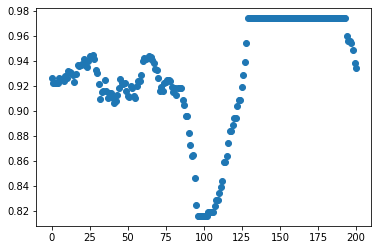

In [17]:
gen = logbook.select("gen")
avgs = []

for i in gen:
    avgs.append(logbook[i]['media'])

#plt.ylim([0,1])
plt.scatter(gen,avgs)

In [15]:
logbook

[{'gen': 0,
  'nevals': 50,
  'media': 0.9259999999999999,
  'std': 0.04182104733265296,
  'max': 0.975,
  'min': 0.8},
 {'gen': 1,
  'nevals': 10,
  'media': 0.9219999999999999,
  'std': 0.04290687590584985,
  'max': 0.975,
  'min': 0.8},
 {'gen': 2,
  'nevals': 10,
  'media': 0.922,
  'std': 0.04348562981031778,
  'max': 0.975,
  'min': 0.8},
 {'gen': 3,
  'nevals': 10,
  'media': 0.9219999999999999,
  'std': 0.04348562981031778,
  'max': 0.975,
  'min': 0.8},
 {'gen': 4,
  'nevals': 10,
  'media': 0.9224999999999999,
  'std': 0.04479118216792228,
  'max': 0.975,
  'min': 0.8},
 {'gen': 5,
  'nevals': 10,
  'media': 0.9259999999999999,
  'std': 0.04414748010928821,
  'max': 0.975,
  'min': 0.8},
 {'gen': 6,
  'nevals': 10,
  'media': 0.9255000000000001,
  'std': 0.04372928080817245,
  'max': 0.975,
  'min': 0.8},
 {'gen': 7,
  'nevals': 10,
  'media': 0.9255000000000001,
  'std': 0.04911466176204412,
  'max': 0.975,
  'min': 0.75},
 {'gen': 8,
  'nevals': 10,
  'media': 0.924,
  'std